## 60. 単語ベクトルの読み込みと表示
Google Newsデータセット（約1,000億単語）での学習済み単語ベクトル（300万単語・フレーズ，300次元）をダウンロードし，”United States”の単語ベクトルを表示せよ．ただし，”United States”は内部的には”United_States”と表現されていることに注意せよ．

In [ ]:
from gensim.models import KeyedVectors

googlenews = KeyedVectors.load_word2vec_format(
    '../../data/GoogleNews-vectors-negative300.bin', binary=True)

# print(googlenews.vector_size)
print(googlenews['United_States'])

## 61. 単語の類似度
“United States”と”U.S.”のコサイン類似度を計算せよ．

In [ ]:
import numpy as np

'''
コサイン類似度
cos(a. b) = a・b / |a||b|

内積...                    a・b = np.dot(a, b)
ベクトルの大きさ（ノルム）...  |a| = np.linalg.nor()
'''

def cos_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


cos_sim = cos_similarity(
    googlenews['United_States'], googlenews['U.S.'])
print(cos_sim)


## 62. 類似度の高い単語10件
“United States”とコサイン類似度が高い10語と，その類似度を出力せよ．

In [ ]:
most_similar = googlenews.similar_by_word('United_States')

for word, cos_sim in most_similar:
    print('%s\t%f' % (word, cos_sim))

## 63. 加法構成性によるアナロジー
“Spain”の単語ベクトルから”Madrid”のベクトルを引き，”Athens”のベクトルを足したベクトルを計算し，そのベクトルと類似度の高い10語とその類似度を出力せよ．

In [ ]:
# TODO negative と positiveオプションを使う
vector = googlenews['Spain'] - googlenews['Madrid'] + googlenews['Athens']
most_similar = googlenews.similar_by_vector(vector)

for word, cos_sim in most_similar:
    print('%s\t%f' % (word, cos_sim))

## 64. アナロジーデータでの実験
単語アナロジーの評価データをダウンロードし，vec(2列目の単語) - vec(1列目の単語) + vec(3列目の単語)を計算し，そのベクトルと類似度が最も高い単語と，その類似度を求めよ．求めた単語と類似度は，各事例の末尾に追記せよ．

In [ ]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

columns = ['col%d' % (i)for i in range(4)]
questions_words = pd.read_csv(
    '../../data/questions-words.txt', names=columns, sep=' ')
questions_words = questions_words[questions_words.col0 != ':']

# positive とnegativeに入れる変数を修正
def get_most_similar(row):
    most_similar = googlenews.most_similar(
                    positive=[googlenews[row.col1], googlenews[row.col2]],
                    negative=[googlenews[row.col0]],
                    topn=1)[0]
    return pd.Series(list(most_similar))
    

questions_words[['most_similar', 'similarity']] = questions_words.progress_apply(get_most_similar, axis=1)
questions_words.to_csv('../../data/questions_words.csv',
                       header=False, index=False)
questions_words.head(10)


In [171]:
questions_words.head(10)

,col0,col1,col2,col3,most_similar,similarity
0,Athens,Greece,Baghdad,Iraq,Baghdad,0.748983
1,Athens,Greece,Bangkok,Thailand,Bangkok,0.743114
2,Athens,Greece,Beijing,China,China,0.718659
3,Athens,Greece,Berlin,Germany,Germany,0.672089
4,Athens,Greece,Bern,Switzerland,Bern,0.690234
5,Athens,Greece,Cairo,Egypt,Egypt,0.762682
6,Athens,Greece,Canberra,Australia,Canberra,0.740721
7,Athens,Greece,Hanoi,Vietnam,Hanoi,0.750990
8,Athens,Greece,Havana,Cuba,Havana,0.726283
9,Athens,Greece,Helsinki,Finland,Helsinki,0.723530


## 65. アナロジータスクでの正解率
64の実行結果を用い，意味的アナロジー（semantic analogy）と文法的アナロジー（syntactic analogy）の正解率を測定せよ．

In [ ]:
from sklearn.metrics import accuracy_score
columns = ['col0', 'col1', 'col2', 'col3', 'most_similar', 'similarity']
questions_words = pd.read_csv('../../data/questions_words.csv',
                              names=columns)
'''
3列目... 文法的アナロジー
4列目... 意味的アナロジー
'''

accuracy = accuracy_score(questions_words['col3'], questions_words['most_similar'])
print(accuracy)

## 66. WordSimilarity-353での評価
The WordSimilarity-353 Test Collectionの評価データをダウンロードし，単語ベクトルにより計算される類似度のランキングと，人間の類似度判定のランキングの間のスピアマン相関係数を計算せよ．
参考
https://qiita.com/dacciinfo/items/88debe69f9f4e927aafc

In [ ]:
'''
1. ベクトルの類似度をランキングする．
2. combinedの３カラム目でランキングする
3. インデックスのリストが二つできる
4. スピアマン係数を求める
'''


def get_similarity(row):
    return cos_similarity(googlenews[row['Word 1']], googlenews[row['Word 2']])


def spearman(x, y):
    x = np.array(x)
    y = np.array(y)
    N = len(x)
    return 1 - (6*sum((x -y)**2) / (N*(N**2 - 1)))


word_sim = pd.read_csv('../../data/wordsim353/combined.csv')
word_sim['Vector'] = word_sim.apply(get_similarity, axis=1)

human_rank = word_sim.sort_values('Human (mean)').index
vector_rank = word_sim.sort_values('Vector').index
spearman_coefficient = spearman(list(human_rank), list(vector_rank))

print(spearman_coefficient)
'''
0.0653429551674618
'''

## 67. k-meansクラスタリング
国名に関する単語ベクトルを抽出し，k-meansクラスタリングをクラスタ数k=5として実行せよ．

In [ ]:
'''
国連に加入している国のリストを使用 https://www.mofa.go.jp/mofaj/files/000023536.pdf
'''
from sklearn.cluster import KMeans
k = 5


def preprocessor(row):
    return row.replace(' ', '_')


def isin_vocab(x):
    return x in googlenews


countries = pd.read_csv('../../data/countries.csv')
countries['English'] = countries.English.apply(preprocessor)
countries['isin_vocab'] = countries.English.apply(isin_vocab)
countries = countries[countries.isin_vocab]
vec = countries.English.apply(lambda x: googlenews[x]).values
vec = list(vec)

countries['cluster'] = KMeans(n_clusters=k).fit_predict(vec)

for cluster in range(k):
    print('cluster', cluster)
    print(countries[countries['cluster'] == cluster][
          ['Japanese', 'English']].head(5), end='\n\n')


'''
cluster 0
   Japanese       English
2    アルジェリア       Algeria
4      アンゴラ        Angola
18      ベニン         Benin
22     ボツワナ      Botswana
26  ブルキナファソ  Burkina_Faso

cluster 1
   Japanese     English
6    アルゼンチン   Argentina
20     ボリビア     Bolivia
23     ブラジル      Brazil
28   カーボベルデ  Cabo_Verde
34       チリ       Chile

cluster 2
    Japanese      English
0    アフガニスタン  Afghanistan
10  アゼルバイジャン   Azerbaijan
12     バーレーン      Bahrain
13   バングラデシュ   Bangladesh
19      ブータン       Bhutan

cluster 3
   Japanese    English
8   オーストラリア  Australia
11      バハマ    Bahamas
14    バルバドス   Barbados
17     ベリーズ     Belize
49     ドミニカ   Dominica

cluster 4
   Japanese  English
1     アルバニア  Albania
3      アンドラ  Andorra
7     アルメニア  Armenia
9    オーストリア  Austria
15    ベラルーシ  Belarus

'''

## 68. Ward法によるクラスタリング
国名に関する単語ベクトルに対し，Ward法による階層型クラスタリングを実行せよ．さらに，クラスタリング結果をデンドログラムとして可視化せよ．

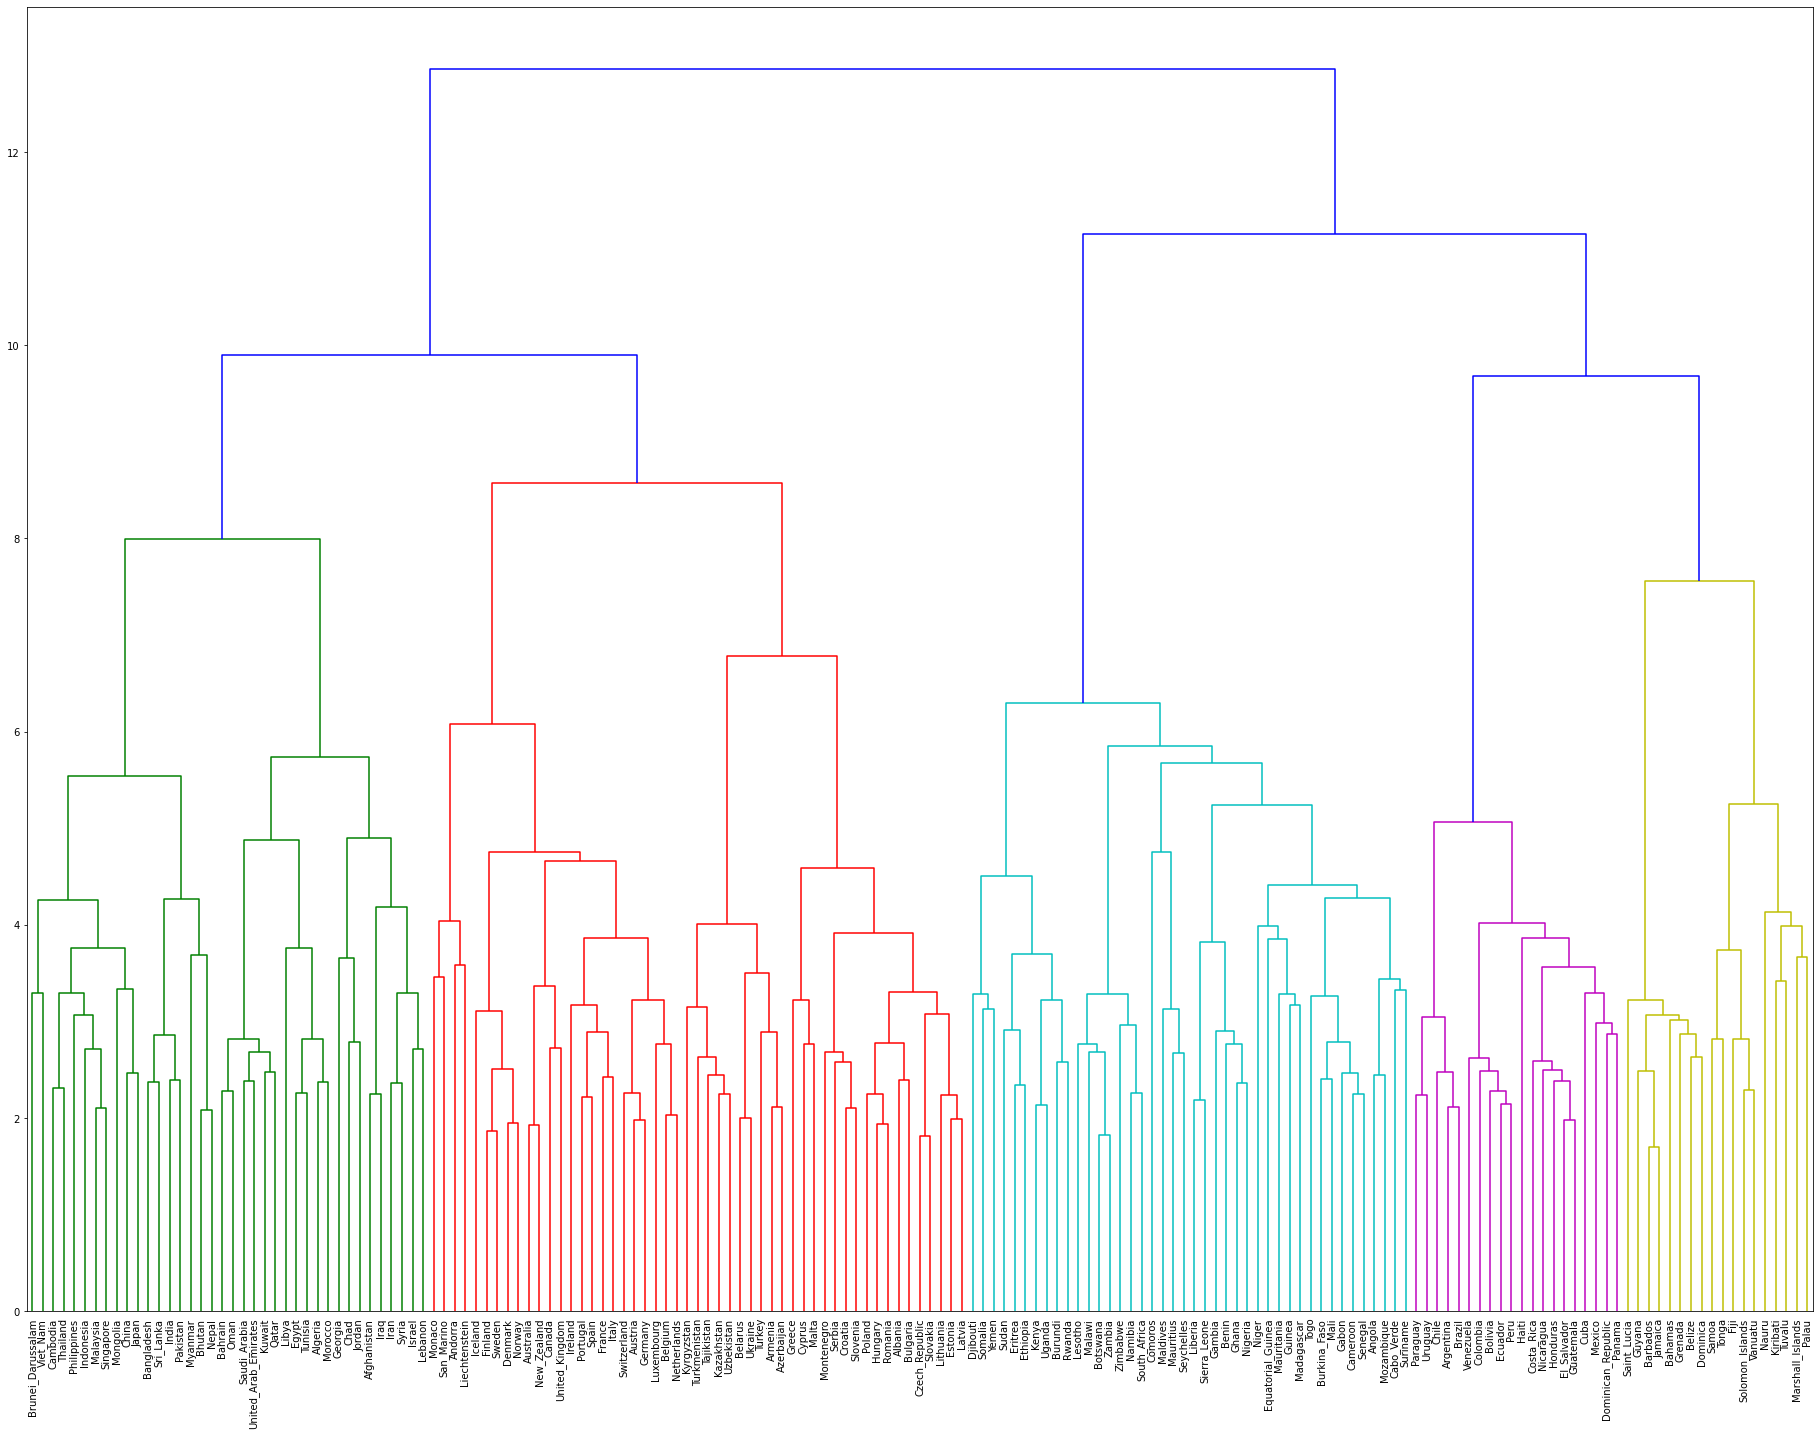

In [168]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

countries = pd.read_csv('../../data/countries.csv')
countries['English'] = countries.English.apply(preprocessor)
countries['isin_vocab'] = countries.English.apply(isin_vocab)
countries = countries[countries.isin_vocab]
vec = countries.English.apply(lambda x: googlenews[x]).values
vec = list(vec)

plt.figure(figsize=(32.0, 24.0))
link = linkage(vec, method='ward')
dendrogram(link,
           labels=countries['English'].values,
           leaf_rotation=90,
           leaf_font_size=10)

plt.show()

## 69. t-SNEによる可視化
国名に関する単語ベクトルのベクトル空間をt-SNEで可視化せよ．

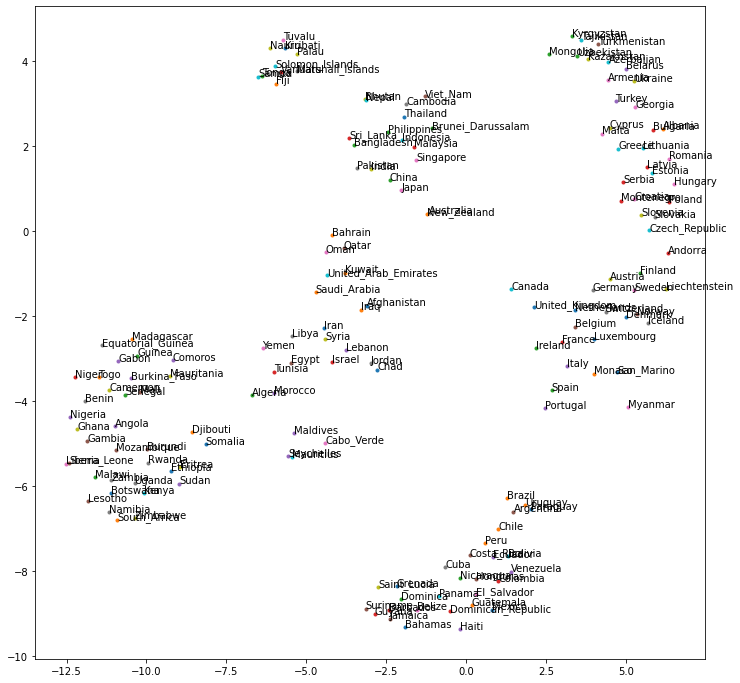

In [170]:
from sklearn.manifold import TSNE
vec = TSNE(n_components=2).fit_transform(vec)  # ２次元に圧縮
x, y = vec.T

plt.figure(figsize=(12, 12))

for (xi, yi, label) in zip(x, y, countries['English'].values):
  plt.plot(xi, yi, '.')
  plt.annotate(label, xy=(xi, yi))
plt.show()